In [37]:
from sklearn import preprocessing
import json

SETSofVALS = 25
def generateHeader():
    header = []
    for i in range(1,SETSofVALS+1):
        header.append("x"+str(i))
        header.append("y"+str(i))
        header.append("z"+str(i))
        header.append("block"+str(i))
    header.append("biome")
    return header

def encodeNsave_columns_dummy(df, header, file):
    blockCols = {'blocks': []}
    for i in range(1, SETSofVALS+1):
        encodeNsave_text_dummy(df,header+str(i), blockCols)
    return blockCols
  #  with open(file, 'w') as outfile:
      #  json.dump(blockCols, outfile)

def encodeNsave_text_dummy(df, name, blockCols):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    blockCols['blocks'].append({name:dummies.columns.tolist()})
    
        
#code below taken from https://github.com/jeffheaton/t81_558_deep_learning
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)
    
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

In [38]:
import pandas as pd
import os
import io
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

dataPath = "./Data/"
weightPath = "./Weights/"
dataFile = os.path.join(dataPath,"data_cleaned4.csv")
#filename_write = os.path.join(dataPath,"data_cleaned3_OOS.csv")

df = pd.read_csv(dataFile, na_values=['NA','?'])

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
biomes = encode_text_index(df,"biome")
blocksObj = encodeNtrack_columns_dummy(df, "block")

x,y = to_xy(df,"biome")

#make a holdout set (for model validation) and main (for training and testing different models)
x_main, x_holdout, y_main, y_holdout = train_test_split(x, y, test_size=0.20) 


# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
bestModel = 0
bestScore = 0

for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
    fName_models = str(fold)+"best_weights.hdf5"
    
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(50, activation='relu')) # Hidden 2
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    #early stopping
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto')
    #getting best weights 
    checkpointer = ModelCheckpoint(filepath=weightPath+fName_models, verbose=0, save_best_only=True) # save best model

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=0,epochs=1000)
    
    model.load_weights(weightPath+fName_models)
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    #getting best model based on score
    if bestScore < score:
        bestModel = fold
        bestScore = score
        
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print("Final score (accuracy): {}".format(score))    
    
# Write the cross-validated prediction
#oos_y = pd.DataFrame(oos_y)
#oos_pred = pd.DataFrame(oos_pred)
#oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
#oosDF.to_csv(filename_write,index=False)


/Users/saadghani/Development/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Fold #1
Epoch 00124: early stopping
Fold score (accuracy): 0.6229166666666667
Fold #2
Epoch 00103: early stopping
Fold score (accuracy): 0.5940972222222223
Fold #3
Epoch 00100: early stopping
Fold score (accuracy): 0.5989583333333334
Fold #4
Epoch 00125: early stopping
Fold score (accuracy): 0.6052083333333333
Fold #5
Epoch 00126: early stopping
Fold score (accuracy): 0.6072916666666667
Final score (accuracy): 0.6056944444444444


In [39]:
#loading best model
model.load_weights(weightPath+str(bestModel)+'best_weights.hdf5') 
pred = model.predict(x_holdout)

predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_holdout,axis=1)
print(f"Predictions: {predict_classes}")
print(f"Expected: {expected_classes}")

correct = metrics.accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")


Predictions: [ 1  2 10 ...  6  2  4]
Expected: [4 2 7 ... 1 2 8]
Accuracy: 0.6086111111111111


Confusion matrix, without normalization
[[286   0   0   0   0   0   0   6   0   0   0   0]
 [  4 105   0   5  16   6  23   8  15   5  89   2]
 [  3   0 268   3   0   0   0   7   0   0   0   0]
 [  3   4   0 153   3   9   0   4  24  90   0   8]
 [ 12  11   0   1 115  22  20  13  78  14   3   1]
 [  0   1   2   5  17 259   6   4   1  39   0   0]
 [ 25  25   0   0  26   9 204   8   3   3  16   0]
 [114  10   4   0   8  12  15 100   3   0   9   2]
 [  0  10   1   3  78  18   3   2 151  35   2   1]
 [  1   8   0  55   8  41   3   4  42 142   1   5]
 [  4  55   2   0   5   0   8   5   7   1 241   1]
 [  0   2   0  57   2   7   1   2   5  45   0 167]]
Normalized confusion matrix
[[0.98 0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.  ]
 [0.01 0.38 0.   0.02 0.06 0.02 0.08 0.03 0.05 0.02 0.32 0.01]
 [0.01 0.   0.95 0.01 0.   0.   0.   0.02 0.   0.   0.   0.  ]
 [0.01 0.01 0.   0.51 0.01 0.03 0.   0.01 0.08 0.3  0.   0.03]
 [0.04 0.04 0.   0.   0.4  0.08 0.07 0.04 0.27 0.05 0.01 0.  ]
 [0.

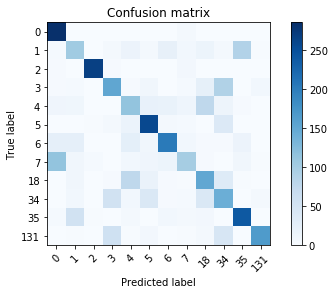

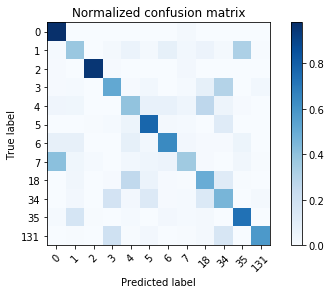

In [40]:
#evaluating data graphically
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

pred = model.predict(x_holdout)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_holdout,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, biomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, biomes, title='Normalized confusion matrix')

plt.show()

In [45]:
#saving network with meta info
dnnPath = "./DNNs/"
metaFile = os.path.join(dnnPath,"meta1.json")

#create json object
jsonObj = {'biomes':biomes.tolist()}
jsonObj.update(blocksObj)

with open(metaFile, 'w') as outfile:
    json.dump(jsonObj, outfile)

model.save(os.path.join(dnnPath,"network1.h5"))